In [1]:
# import modules
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from transformers import DonutProcessor, VisionEncoderDecoderModel
from PIL import Image
import matplotlib.pyplot as plt

/home/mingi/anaconda3/envs/tinyllava_factory/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/home/mingi/data/mmc/mmc_instruction_non-arxiv_images'
file_names = os.listdir(data_path)

In [3]:
model_name = "khhuang/chart-to-table"
model = VisionEncoderDecoderModel.from_pretrained(model_name).cuda()
processor = DonutProcessor.from_pretrained(model_name)
# Format text inputs

input_prompt = "<data_table_generation> <s_answer>"

/home/mingi/anaconda3/envs/tinyllava_factory/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/mingi/anaconda3/envs/tinyllava_factory/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
def inference_plot(model, processor, data_path, file_names, idx):
    
    # Encode chart figure and tokenize text
    img = Image.open(os.path.join(data_path, file_names[idx])).convert("RGB")
    pixel_values = processor(img, random_padding=False, return_tensors="pt").pixel_values
    pixel_values = pixel_values.cuda()
    decoder_input_ids = processor.tokenizer(input_prompt, add_special_tokens=False, return_tensors="pt", max_length=510).input_ids.cuda()#.squeeze(0)

    outputs = model.generate(
        pixel_values.cuda(),
        decoder_input_ids=decoder_input_ids.cuda(),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=4,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )
    

    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    extracted_table = sequence.split("<s_answer>")[1].strip()
    
    print(extracted_table)    
    
    plt.imshow(img)
    plt.axis("off")
    plt.show()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


TITLE | Public sector expenditure on water supply in the United Kingdom (UK) from 2009/10 to 2019/20 (in million GBP) &&& Expenditure in million GBP | Year &&& 800 | 2019/20 &&& 799 | 2018/19 &&& 793 | 2017/18 &&& 754 | 2016/17 &&& 583 | 2015/16 &&& 575 | 2014/15 &&& 627 | 2013/14 &&& 629 | 2014/15 &&& 636 | 2013/14 &&&& 629 | 2012/13 &&&& 1.01 | 2012/13 &&&& 148 | Total Shanglarly &&&& 158 | Total Shanglark &&&&&&&&&&&& 158 | Total Shanglark &&&&&&&&&&&&&&&&&& 158 | None day and total expenditure on Twitter &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Total weekly and total expenditure on Twitter and the weekly &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total T

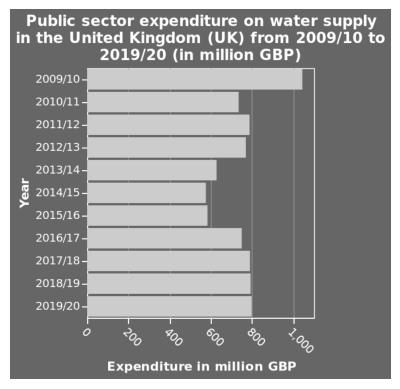

In [5]:
inference_plot(model, processor, data_path, file_names, idx=10)